In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from Bio import SeqIO
from sklearn.cluster import AffinityPropagation, KMeans, DBSCAN
from sklearn.manifold import MDS, t_sne, Isomap
from util.isoelectric_point import isoelectric_points

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Problem Statement

If I'm given a list of samples, how do I figure out what samples are similar to one another?

Here, we will explore this problem by using biological sequence data.

In [19]:
sequences = [s for s in SeqIO.parse('data/human_h1_aligned_downsampled.fasta', 'fasta')]
sequences[0:5]

[SeqRecord(seq=Seq('---------MKAKLLVLLCAFTATYADTICIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='CY000449', name='CY000449', description='CY000449', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVMLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='CY043094', name='CY043094', description='CY043094', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='KC781514', name='KC781514', description='KC781514', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='KC891176', name='KC891176', description='KC891176', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='CY063807', name='CY063807', description='CY063807', dbxrefs=[])]

In [20]:
seqids = [s.id for s in SeqIO.parse('data/human_h1_aligned_downsampled.fasta', 'fasta')]
seqids[0:5]

['CY000449', 'CY043094', 'KC781514', 'KC891176', 'CY063807']

In [21]:
seq_df = pd.DataFrame(sequences)
seq_df.index = seqids
seq_df = seq_df.replace(isoelectric_points.keys(), isoelectric_points.values()).replace('-', 0)
seq_df.head()

,0,1,2,3,4,5,6,7,8,9,...,606,607,608,609,610,611,612,613,614,615
CY000449,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
CY043094,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
KC781514,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
KC891176,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
CY063807,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0


In [22]:
ap = AffinityPropagation()
ap_cluster_labels = ap.fit_predict(seq_df)  # gets the cluster labels.
ap_cluster_labels[0:5]

array([30,  4,  0, 22,  1])

In [23]:
# Use multi-dimensional scaling (MDS) to get a 2-D plane representation of the data, so that we can plot it.
mds = MDS()
mds_coords = mds.fit_transform(seq_df)

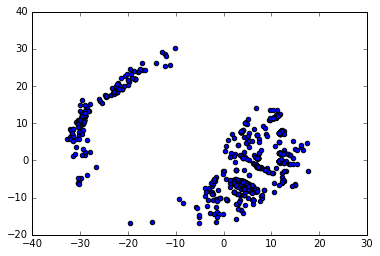

In [24]:
plt.scatter(mds_coords[:,0], mds_coords[:,1])

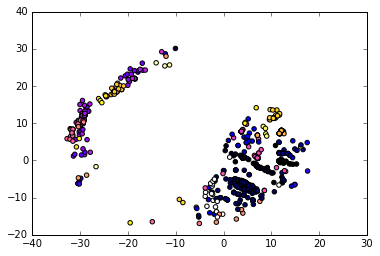

In [25]:
# Colour the clusters by cluster number, then plot on MDS plot.
cmap = plt.cm.get_cmap('gnuplot2', len(ap_cluster_labels))

plt.scatter(mds_coords[:,0], mds_coords[:,1], c=ap_cluster_labels, cmap=cmap)

# Evaluating clustering results

* Silhouette score

# Exercises (10 min)

Use K-means to cluster the data. See if you can colour the 2 clusters in an MDS plot.

In [26]:
km = KMeans(n_clusters=2)
km_cluster_labels = km.fit_predict(seq_df)
km_cluster_labels[0:5]

array([0, 1, 1, 1, 1], dtype=int32)

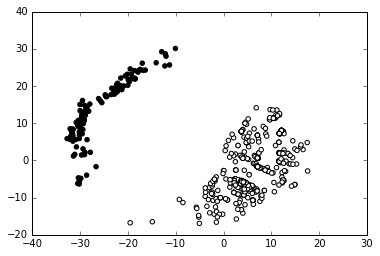

In [27]:
cmap = plt.cm.get_cmap('gnuplot2', len(km_cluster_labels))

plt.scatter(mds_coords[:,0], mds_coords[:,1], c=km_cluster_labels, cmap=cmap)

For comparison, try the DBSCAN algorithm, and do the same thing.

In [28]:
dbs = DBSCAN()
dbs_cluster_labels = dbs.fit_predict(seq_df)
dbs_cluster_labels[0:5]

array([-1,  0,  1, -1,  2])

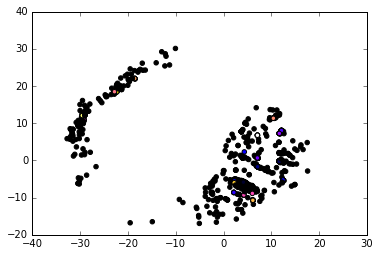

In [29]:
cmap = plt.cm.get_cmap('gnuplot2', len(dbs_cluster_labels))

plt.scatter(mds_coords[:,0], mds_coords[:,1], c=dbs_cluster_labels, cmap=cmap)

In [30]:
# What are the silhouette scores for each of the 3 algorithms?

# Takeaways

1. Clustering: It's all about figuring out what samples are similar to one another.
    * `clusterer.fit_predict(data)`
1. Manifold Learning: It's all about finding a low-dimensional representation of high-dimensional data.
    * `manifold.fit_transform(data)`
1. Evaluation: Check how good the clustering is by using the silhouette score.